In [1]:
from fastai import *
from fastai.vision.all import *

assert(torch.cuda.is_available())

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['figure.dpi'] = 150

im_path = Path('GatherData/data/pic/crop/base/')

df = pd.read_csv('GatherData/data/base_meta.csv', index_col = 0)

#rename the filename column
cols = df.columns
df.columns = ['fname'] + cols[1:].tolist()

In [2]:
df.head()

,fname,y1,y2,x1,x2,label,project,background,angle,groups,usability,orientation
0,base_correct_black_1.JPG,69.590335,558.880658,124.816116,907.680633,correct,base,black,side,1,ok,L
1,base_correct_black_2.JPG,145.977432,567.138722,202.854826,876.712891,correct,base,black,top,1,ok,L
2,base_correct_black_3.JPG,36.558077,575.396787,150.003213,1012.145149,correct,base,black,top,1,ok,R
3,base_correct_black_4.JPG,51.009690,618.751626,94.261278,1002.648374,correct,base,black,side,1,ok,R
4,base_correct_black_5.JPG,26.235496,602.235496,57.099987,978.699987,correct,base,black,side,2,ok,R


In [3]:
def get_df(df, val_method = 'groups', background = None, val_pct = 0.2, 
           angle = None, unique = True, orientation = None, verbose = True, seed = 44):
    df_ok = df[df.usability == 'ok'].copy()
    
    np.random.seed(seed)
    
    if angle:
        assert(angle in ['top', 'side']), 'Pick a valid angle'
        if verbose: print('Reduce the dataframe to only {} angle photos'.format(angle))
        df_ok = df_ok[df_ok.angle == angle]
   
    if orientation:
        assert(orientation in ['L','R']), 'Pick a valid orientation'
        if verbose: print('Reduce the dataframe to only {} oriented photos'. format(orientation))
        df_ok = df_ok[df_ok.orientation == orientation]
        
    groups = np.array(df_ok.groups.unique())
    
    if val_method == 'background': # the model is validated on an unseen background
        if verbose: print('Build the validation set by background')
        if background not in df_ok.background.unique():
            background = random.choice(df_ok.background.unique())
            if verbose: print('Pick the background {} at random'.format(background))
        else:
            if verbose: print('Pick the background {}'.format(background))
            
        is_valid = df_ok.background == background
        
    elif val_method == 'groups': # the model is validated on unseen groups
        if verbose: print('Building the validation set from groups, picking {}% of the groups at random'.format(val_pct * 100))
        total_groups = len(groups) 
        val_no = int(val_pct * total_groups)
        
        is_valid = df_ok.groups.isin(np.random.choice(groups, val_no))
    
    else:
        if verbose: print('Pick a valid validation method')
        return None
    
    df_ok['is_valid'] = is_valid    
    
    if unique: # all instances of a group are considered for validation
        if verbose: print('Reduce the dataframe, so for every group in the training there is only one unique item')
        df_unique = pd.DataFrame(columns = df_ok.columns)
        for group in groups: # in none of the validation methods, a group should appear in both training and validation set
            df_tmp = df_ok[df_ok.groups == group]
            if df_tmp.iloc[0]['is_valid']:
                df_unique = df_unique.append(df_tmp, ignore_index = True)
            else:
                df_unique = df_unique.append(df_tmp.sample(1), ignore_index = True)
        df_ok = df_unique
   
    print('Total items: {} of which the in validation set: {} '.format(df_ok.shape[0], df_ok.is_valid.sum()))
    return df_ok[['fname','label','is_valid']]

def get_x(x):
    return f'{im_path}/'+x.fname

def get_y(x):
    return x.label

def get_blocks(size, trans_mult = 1.):
    dBlock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       splitter = ColSplitter(),
                       get_x = ColReader('fname', pref=im_path),
                       get_y = ColReader('label'),
                       item_tfms = Resize((640, int(640 * 1.6)), method = 'squash', pad_mode = 'zeros'),
                       batch_tfms = aug_transforms(size = (size, int(size * 1.6)),
                                                   max_rotate = 10.,
                                                   min_zoom = 0.95,
                                                   max_zoom = 1.05,
                                                   p_affine = 0.8,
                                                   p_lighting = 0.8,
                                                   max_lighting = 0.3,
                                                   max_warp = 0.0,
                                                   mult = trans_mult
                                                  )
                      )
    return dBlock

def get_learner(size = 224, bs = None, arch = resnet34):
    if not bs:
        bs = int(64 * 224 / size)
        
    blks = get_blocks(size)
    df_res = get_df(df, 
                    angle = None, 
                    orientation = None,
                    val_pct = 0.2,
                    val_method = 'groups', 
                    background = None,
                    unique = True,
                    verbose = False,
                    seed = 44
                   )
    
    dls = blks.dataloaders(df_res, bs = bs)
    
    return cnn_learner(dls, arch, metrics=accuracy, ps = 1).to_fp16(), dls, df_res

In [4]:
###sanity check
#for angle in [None, 'top', 'side']:
#    for orientation in [None, 'L', 'R']:
#        for val_method in ['background', 'groups']:
#                for background in df.background.unique():
#                    for unique in [True, False]:
#                        get_df(df, 
#                               angle = angle, 
#                               orientation = orientation,
#                               val_pct = 0.2,
#                               val_method = val_method, 
#                               background = background,
#                               unique = unique,
#                               verbose = False)
#print('fine')

In [6]:
learn, dls, df_res = get_learner(224, 64, xresnet18)

Total items: 346 of which the in validation set: 134 


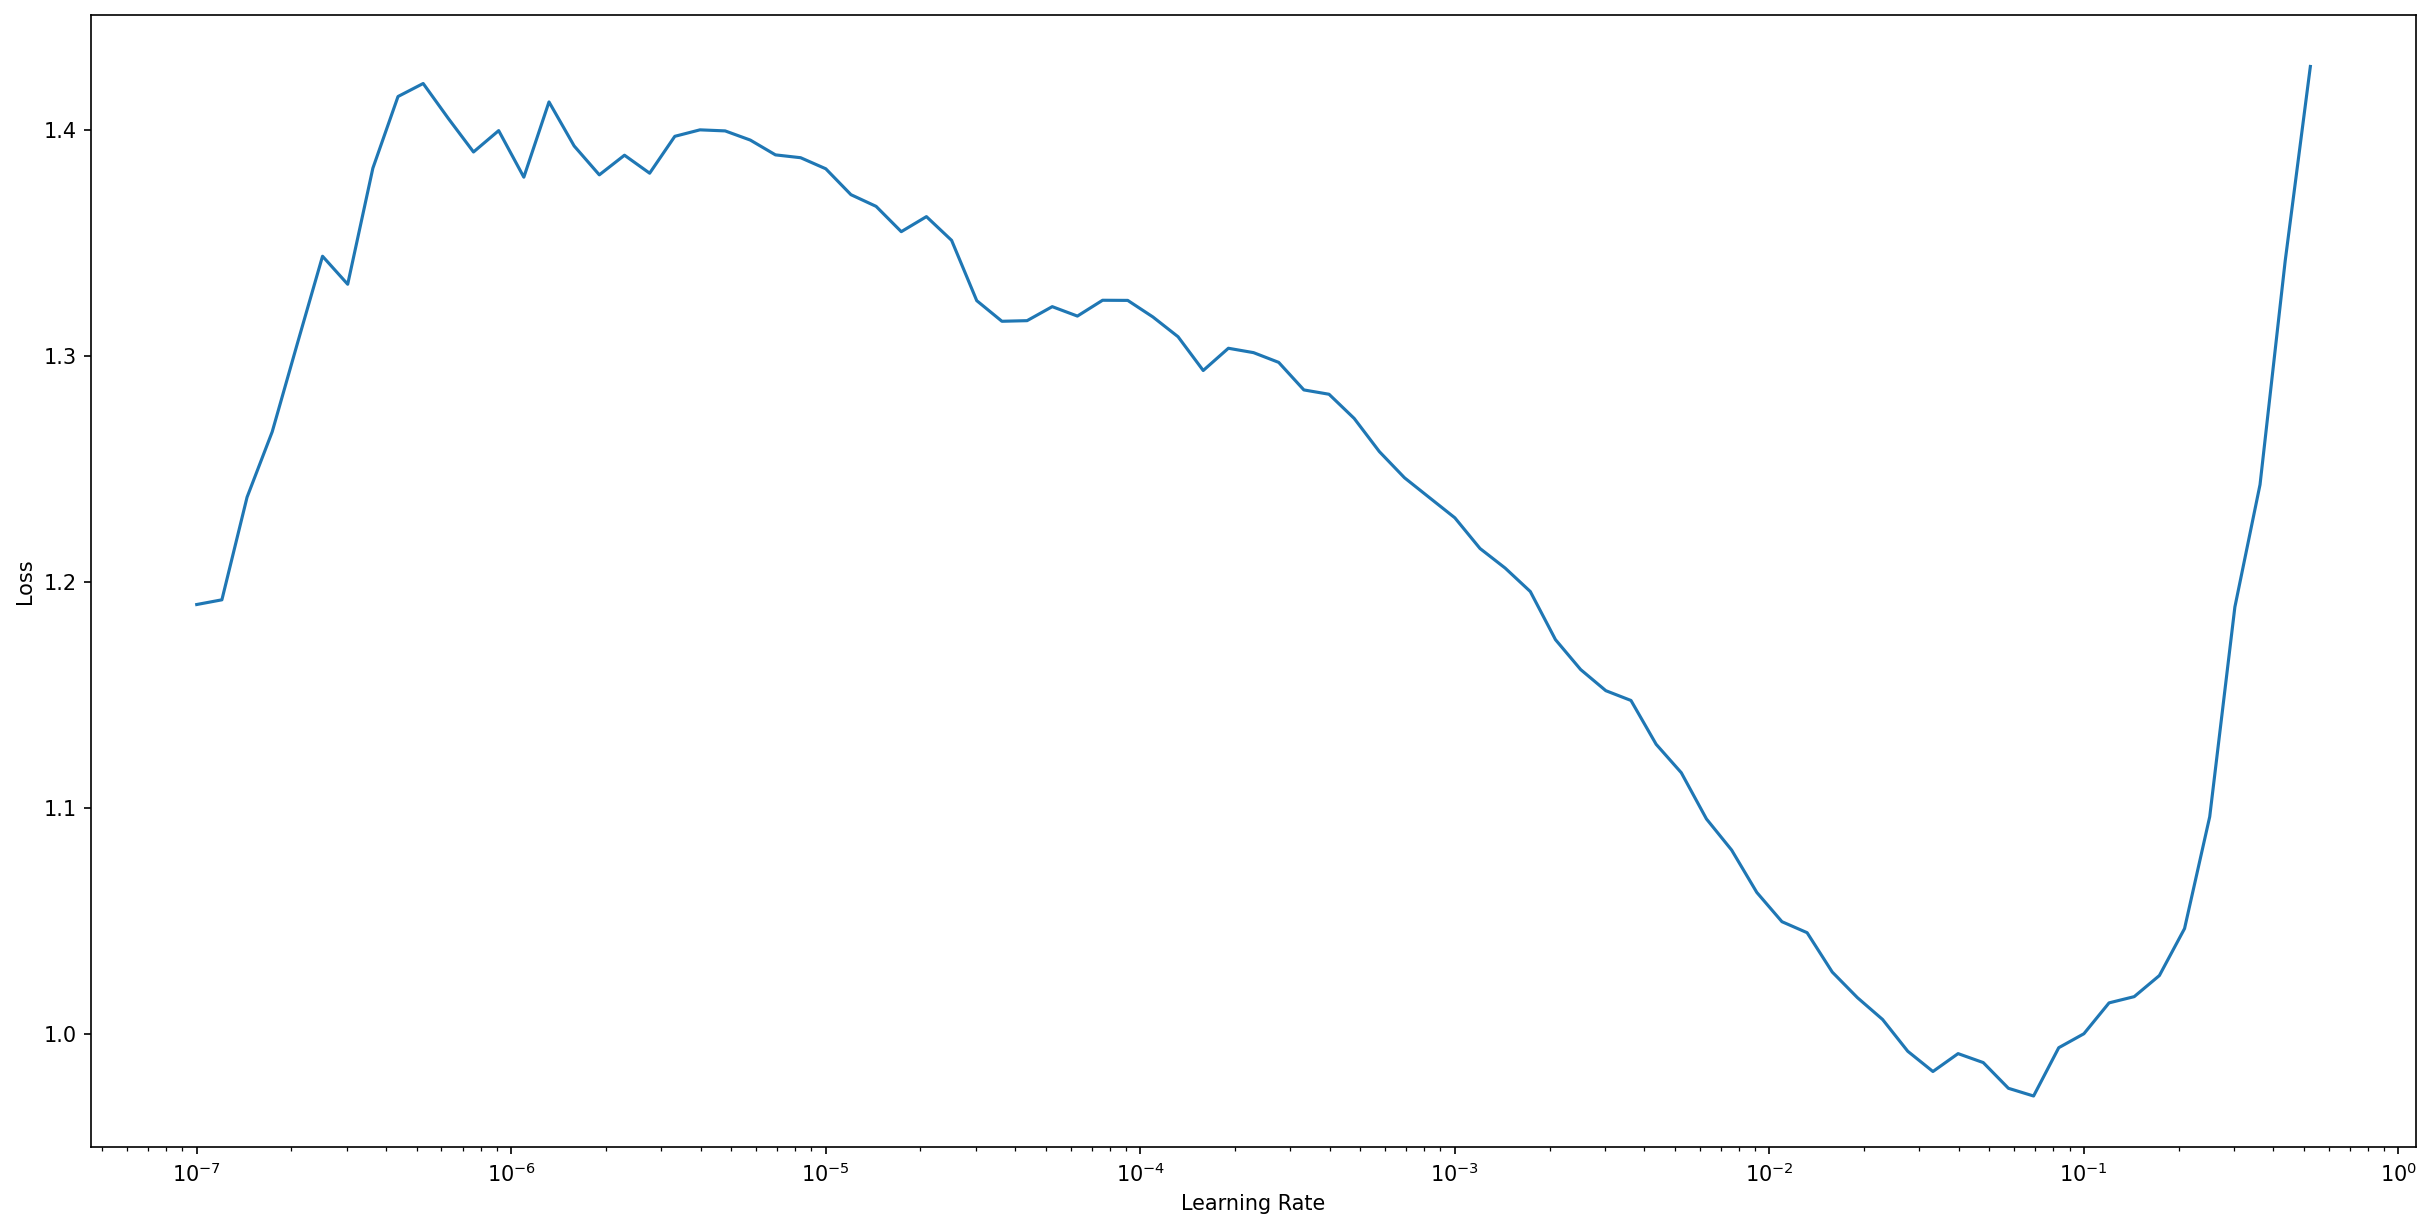

In [7]:
lr_min, _ = learn.lr_find()

In [44]:
# res 'non-crop' / 'side' / 'xresnet18'
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.313927,None,None,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.971096,None,None,00:10
1,0.850760,None,None,00:10
2,0.805935,None,None,00:10
3,0.782933,None,None,00:10
4,0.717060,None,None,00:10
5,0.677359,None,None,00:10
6,0.634280,None,None,00:10
7,0.605393,None,None,00:10
8,0.579515,None,None,00:10
9,0.546545,None,None,00:10


In [45]:
learn.save('tmp')

Path('models/tmp.pth')

Total items: 249 of which the in validation set: 59 


/home/karrrrrrrr/anaconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


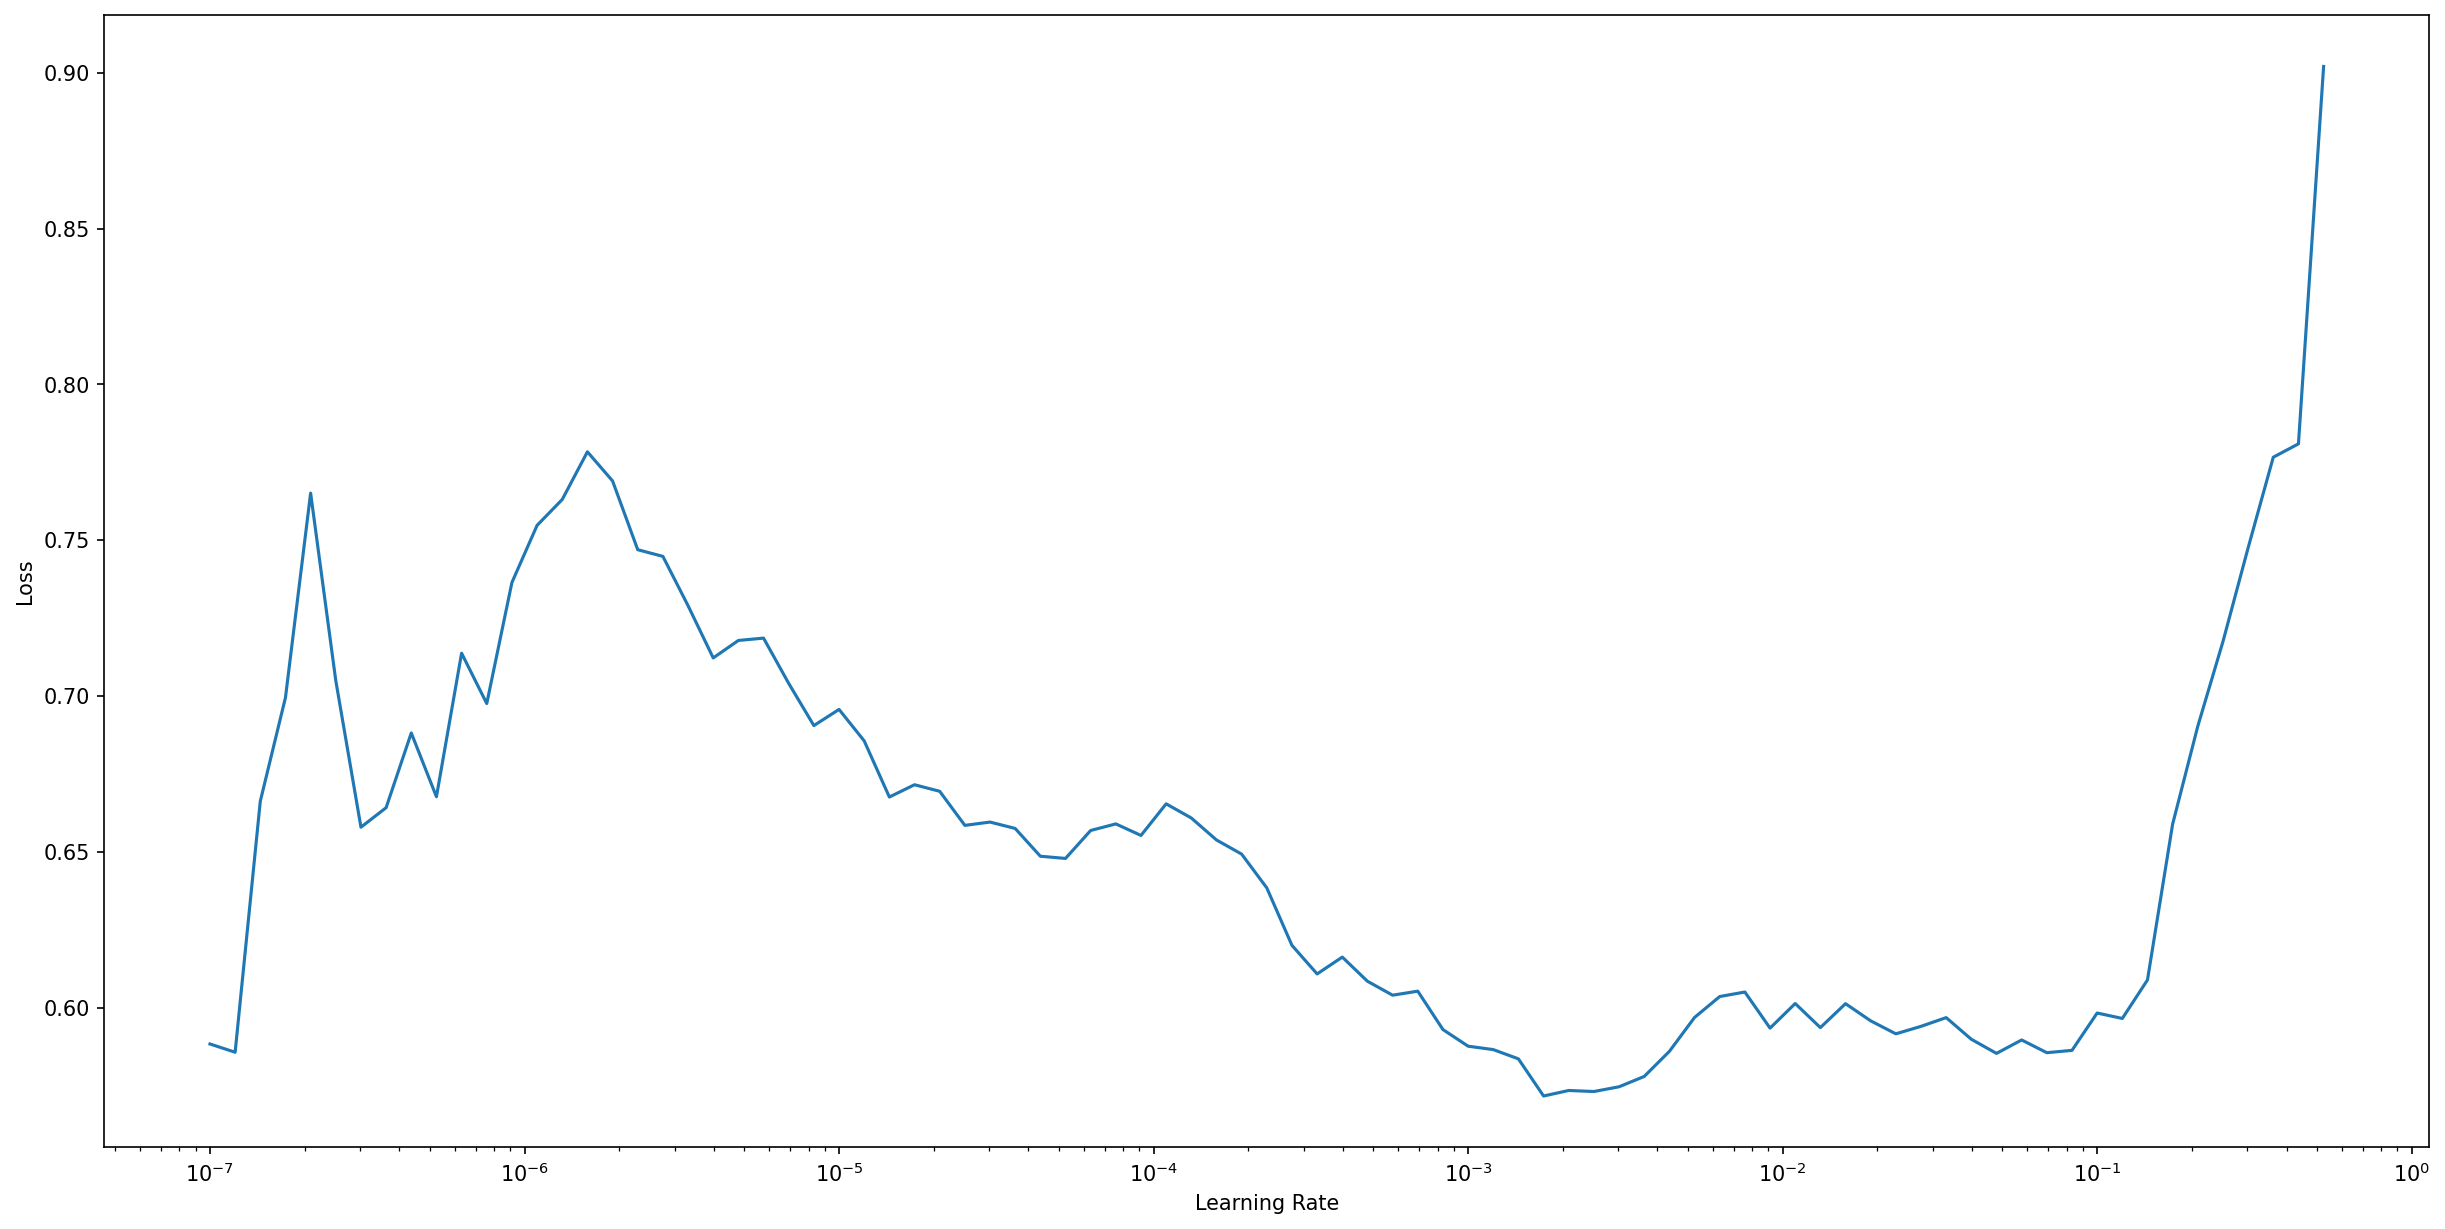

In [46]:
del(dls)
del(learn)
torch.cuda.empty_cache()
learn, dls = get_learner(440, 32, xresnet18)
learn.load('tmp')
lr_min, _ = learn.lr_find()

In [47]:
learn.fine_tune(10, 1.5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.562146,None,None,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.512806,None,None,00:09
1,0.423155,None,None,00:09
2,0.386637,None,None,00:09
3,0.365406,None,None,00:09
4,0.394507,None,None,00:09
5,0.386369,None,None,00:08
6,0.379384,None,None,00:09
7,0.370640,None,None,00:09
8,0.342486,None,None,00:08
9,0.329432,None,None,00:09


In [48]:
learn.save('tmp')

Path('models/tmp.pth')

Total items: 249 of which the in validation set: 59 


/home/karrrrrrrr/anaconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


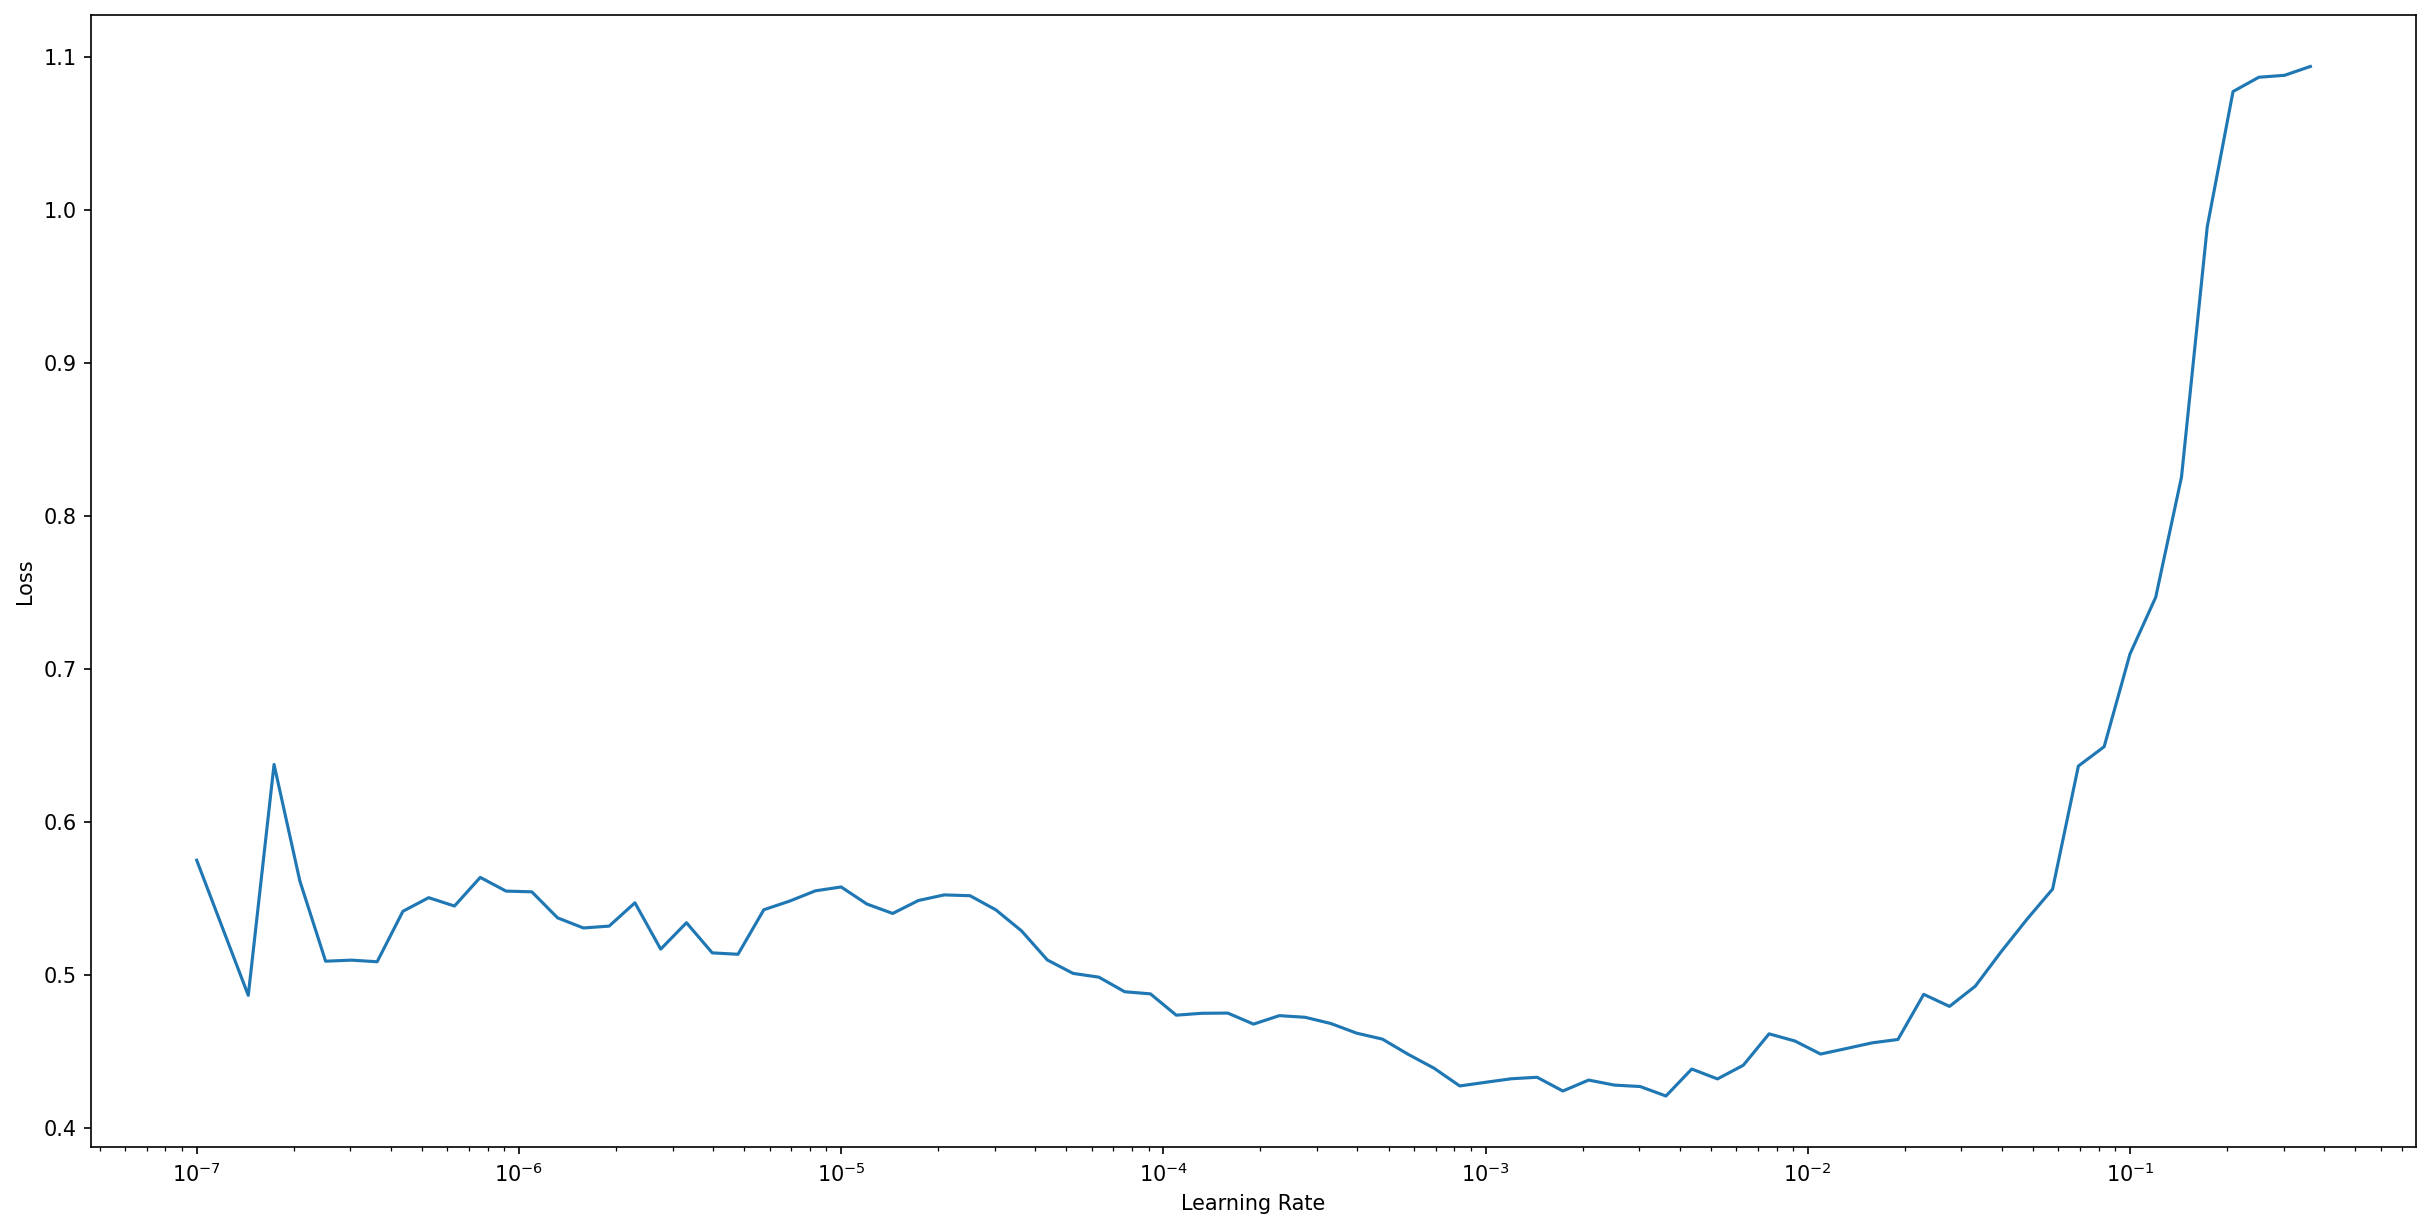

In [49]:
del(dls)
del(learn)
torch.cuda.empty_cache()
learn, dls = get_learner(640, 16, xresnet18)
learn.load('tmp')
lr_min, _ = learn.lr_find()

In [50]:
learn.fine_tune(10, 2e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.475451,None,None,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.435641,None,None,00:10
1,0.362378,None,None,00:10
2,0.430355,None,None,00:10
3,0.425994,None,None,00:10
4,0.437804,None,None,00:10
5,0.448412,None,None,00:09
6,0.405145,None,None,00:10
7,0.402662,None,None,00:10
8,0.397448,None,None,00:10
9,0.399115,None,None,00:10


In [53]:
learn.save('xres18_base_224-640')

Path('models/xres18_base_224-640.pth')

## Export learner for inference ##

In [10]:
learn.load('xres18_base_224-640')
learn.model.eval()
learn.export('models/base.pkl')

## Copy model to app folder

In [11]:
!cp models/base.pkl ../RoboApp/models

### ----------End----------